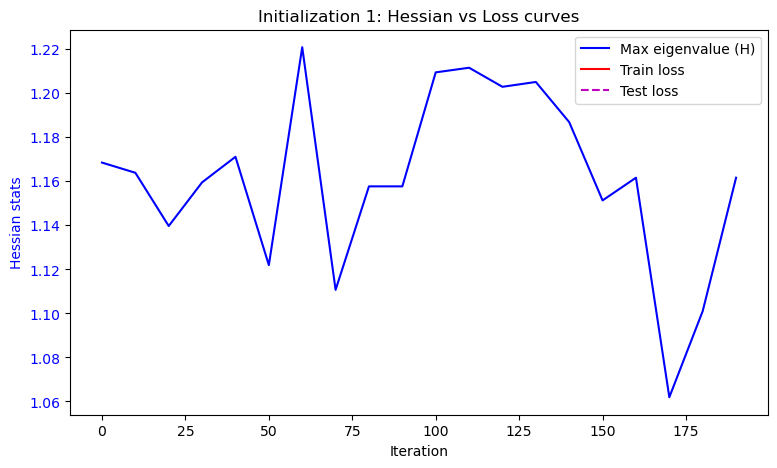

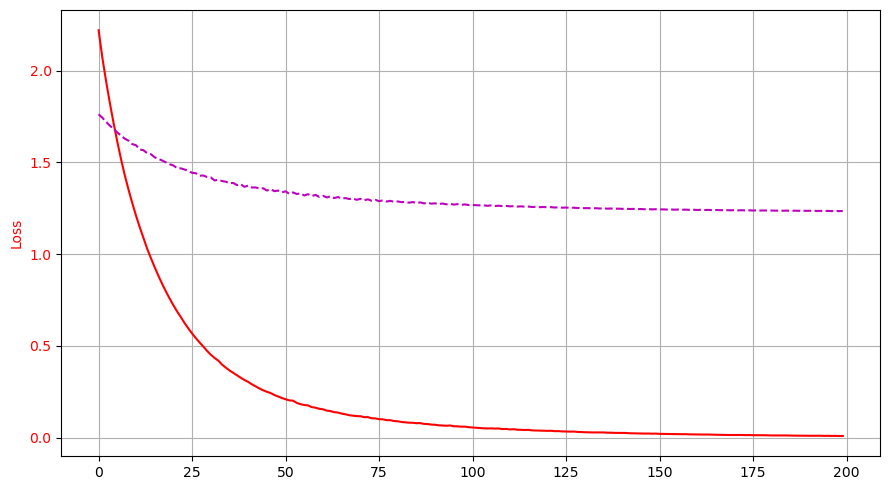

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Settings
# -------------------------------
d = 200
n = 100
n_test = 200
sigma = 0.1
lr = .6
T = 200
device = "cpu"
torch.manual_seed(0)

# -------------------------------
# Generate training and test data
# -------------------------------
w_star = torch.randn(d, device=device)
w_star /= w_star.norm()

def sample_data(n, d, w_star, sigma):
    y = torch.randint(0, 2, (n,), device=device, dtype=torch.float32) * 2 - 1
    z = sigma * torch.randn(n, d, device=device)
    x = y[:, None] * w_star + z
    return x, y

x_train, y_train = sample_data(n, d, w_star, sigma)
x_test, y_test = sample_data(n_test, d, w_star, sigma)

# -------------------------------
# Loss and Hessian helpers
# -------------------------------
def loss_fn(w, v, x, y):
    scores_w = x @ w
    scores_v = x @ v
    preds = torch.maximum(scores_w, scores_v)
    return ((preds - y)**2).mean()

def hessian_stats(w, v):
    wv = torch.cat([w, v])
    f = loss_fn(w, v, x_train, y_train)
    H = torch.autograd.functional.hessian(lambda wv_: loss_fn(wv_[:d], wv_[d:], x_train, y_train), wv)
    H = H.detach().cpu().numpy()
    eigvals = np.linalg.eigvalsh(H)
    return eigvals.max().real, eigvals.sum().real

# -------------------------------
# Training loop
# -------------------------------
num_inits = 1
results = []

for init_id in range(num_inits):
    w = torch.randn(d, device=device, requires_grad=True)
    v = torch.randn(d, device=device, requires_grad=True)

    train_losses = []
    test_losses = []
    iters_loss = []
    max_eigs = []
    traces = []
    iters_hess = []

    for t in range(T):
        loss = loss_fn(w, v, x_train, y_train)
        loss.backward()

        with torch.no_grad():
            w -= lr * w.grad
            v -= lr * v.grad
        w.grad.zero_()
        v.grad.zero_()

        # Track losses every iteration
        with torch.no_grad():
            train_losses.append(loss.item())
            test_losses.append(loss_fn(w, v, x_test, y_test).item())
            iters_loss.append(t)

        # Compute Hessian stats every 10 steps
        if t % 10 == 0:
            maxeig, tr = hessian_stats(w.detach(), v.detach())
            max_eigs.append(maxeig)
            traces.append(tr)
            iters_hess.append(t)

    results.append((iters_loss, train_losses, test_losses, iters_hess, max_eigs, traces))

# -------------------------------
# Plotting
# -------------------------------
for i, (iters_loss, train_losses, test_losses, iters_hess, max_eigs, traces) in enumerate(results):
    fig, ax1 = plt.subplots(figsize=(9, 5))

    # Left axis: Hessian stats
    ax1.plot(iters_hess, max_eigs, 'b-', label='Max eigenvalue (H)')
    #ax1.plot(iters_hess, traces, 'c--', label='Trace (H)')
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Hessian stats", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    fig, ax2 = plt.subplots(figsize=(9, 5))
    # Right axis: losses
    ax2.plot(iters_loss, train_losses, 'r-', label='Train loss')
    ax2.plot(iters_loss, test_losses, 'm--', label='Test loss')
    ax2.set_ylabel("Loss", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Title and legend
    ax1.set_title(f"Initialization {i+1}: Hessian vs Loss curves")
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    plt.grid(True)
    plt.tight_layout()
    plt.show()
